# Imports etc

In [1]:
import itertools
import numpy as np
import pandas as pd
from scipy.stats import bootstrap, spearmanr
from statsmodels.stats.anova import AnovaRM
import os
import plotnine as gg
gg.theme_set(gg.theme_classic)
from scipy.stats import pearsonr

import statsmodels.formula.api as smf

In [2]:
data_save_path = "C:/Users/maria/MEGAsync/SLCNdata/Meta/all_data"
plot_save_path = "C:/Users/maria/MEGAsync/SLCN/MetaSLCNPlots"
if not os.path.exists(plot_save_path):
    os.makedirs(plot_save_path)

# Get human and simulated data

In [3]:
all_data = pd.read_csv(os.path.join(data_save_path, 'all_data.csv'), index_col=0)
all_data_z = pd.read_csv(os.path.join(data_save_path, 'all_data_z.csv'), index_col=0)
all_data_long = pd.read_csv(os.path.join(data_save_path, 'all_data_long.csv'), index_col=0)
all_data_long_z = pd.read_csv(os.path.join(data_save_path, 'all_data_long_z.csv'), index_col=0)

In [4]:
# Save data
r2r_params = pd.read_csv(os.path.join(data_save_path, "r2r_params.csv"), index_col=0)
r2r_params_long = pd.read_csv(os.path.join(data_save_path, "r2r_params_long.csv"), index_col=0)
r2r_params_z = pd.read_csv(os.path.join(data_save_path, "r2r_params_z.csv"), index_col=0)
r2r_params_long_z = pd.read_csv(os.path.join(data_save_path, "r2r_params_long_z.csv"), index_col=0)

In [5]:
param_cats = ['Nalpha', 'Alpha', 'Beta', 'Forget']

# Bootstrap differences!

In [7]:
def my_statistic(x, y, corr_type='spearman'):
    
    if corr_type == 'pearson':
        return pearsonr(x, y)[0]
    elif corr_type == 'spearman':
        return spearmanr(x, y)[0]

x, y = all_data['bf_alpha'], all_data['ps_alpha']
res = bootstrap((x, y), my_statistic, vectorized=False, paired=True)
print(res.confidence_interval)

ConfidenceInterval(low=0.04788464349463498, high=0.2924341609408154)


In [17]:
res_pd = pd.DataFrame()
stat_pd = pd.DataFrame()

for param_cat in param_cats:
    param_names = np.unique(all_data_long[all_data_long['category'] == param_cat]['feature'])
    
    for two_params in itertools.combinations(param_names, r=2):
        if 'bf_nalpha' not in two_params:  # bf_nalpha is always 0, so can't calculate correlation
            
            print(two_params)

            # Bootstrap correlation in human data
            x, y = all_data[two_params[0]], all_data[two_params[1]]
            true_res = bootstrap((x, y), my_statistic, vectorized=False, paired=True)
            true_CI = true_res.confidence_interval
            true_r = my_statistic(x, y)
            new_row = pd.DataFrame({
                'CI_low': [true_CI[0]], 'CI_high': [true_CI[1]], 'r': [true_r],
                'param0': [two_params[0]], 'param1': [two_params[1]],
                'data': ['true']
                })
            res_pd = pd.concat([res_pd, new_row])

            # Bootstrap correlation in simulated data
            x, y = r2r_params[two_params[0]], r2r_params[two_params[1]]
            sim_res = bootstrap((x, y), my_statistic, vectorized=False, paired=True)
            sim_CI = sim_res.confidence_interval
            sim_r = my_statistic(x, y)
            new_row = pd.DataFrame({
                'CI_low': [sim_CI[0]], 'CI_high': [sim_CI[1]], 'r': [sim_r],
                'param0': [two_params[0]], 'param1': [two_params[1]],
                'data': ['sim']
                })
            res_pd = pd.concat([res_pd, new_row])
            
#             true_in_sim_CI = (true_r > sim_CI[0]) and (true_r < sim_CI[1])
#             new_row = pd.DataFrame({
#                 'param0': [two_params[0]], 'param1': [two_params[1]], 'true_in_sim_CI': [true_in_sim_CI],
#             })

('ps_nalpha', 'rl_log_nalpha')
('bf_alpha', 'ps_alpha')
('bf_alpha', 'rl_log_alpha')
('ps_alpha', 'rl_log_alpha')
('bf_1_over_beta', 'ps_1_over_beta')
('bf_1_over_beta', 'rl_epsilon_1_over_beta')
('ps_1_over_beta', 'rl_epsilon_1_over_beta')
('bf_forget', 'rl_forget')


In [18]:
res_pd['param_name'] = res_pd['param0'].apply(lambda x : x.split('_')[-1])
res_pd['tasks'] = res_pd['param0'].apply(lambda x : x.split('_')[0]) + '_' + res_pd['param1'].apply(lambda x : x.split('_')[0])
# res_pd['y'] = (res_pd['CI_low'] + res_pd['CI_high']) / 2
res_pd

,CI_low,CI_high,r,param0,param1,data,param_name,tasks
0,-0.265250,-0.002471,-0.135448,ps_nalpha,rl_log_nalpha,true,nalpha,ps_rl
0,0.252797,0.475845,0.371324,ps_nalpha,rl_log_nalpha,sim,nalpha,ps_rl
0,0.044879,0.289258,0.168899,bf_alpha,ps_alpha,true,alpha,bf_ps
0,0.078639,0.322159,0.200633,bf_alpha,ps_alpha,sim,alpha,bf_ps
0,0.086265,0.326314,0.208357,bf_alpha,rl_log_alpha,true,alpha,bf_rl
0,0.418744,0.606328,0.518876,bf_alpha,rl_log_alpha,sim,alpha,bf_rl
0,-0.129479,0.119987,-0.005717,ps_alpha,rl_log_alpha,true,alpha,ps_rl
0,0.180618,0.406794,0.299486,ps_alpha,rl_log_alpha,sim,alpha,ps_rl
0,0.239569,0.469168,0.360883,bf_1_over_beta,ps_1_over_beta,true,beta,bf_ps
0,0.393708,0.593942,0.501709,bf_1_over_beta,ps_1_over_beta,sim,beta,bf_ps


C:\Users\maria\Anaconda3\envs\noteboot\lib\site-packages\plotnine\utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
C:\Users\maria\Anaconda3\envs\noteboot\lib\site-packages\plotnine\facets\facet.py:487: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
C:\Users\maria\Anaconda3\envs\noteboot\lib\site-packages\plotnine\utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


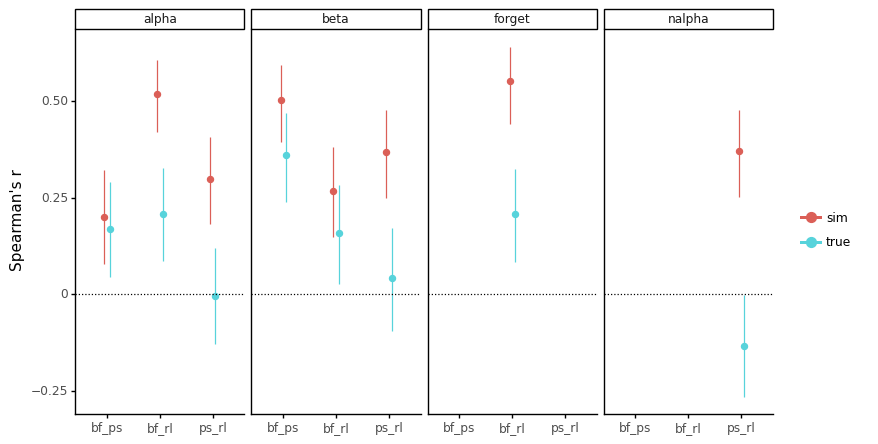

C:\Users\maria\Anaconda3\envs\noteboot\lib\site-packages\plotnine\ggplot.py:719: PlotnineWarning: Saving 9 x 5 in image.
C:\Users\maria\Anaconda3\envs\noteboot\lib\site-packages\plotnine\ggplot.py:722: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/SLCN/MetaSLCNPlots\15_bootstrapped_correlations.png
C:\Users\maria\Anaconda3\envs\noteboot\lib\site-packages\plotnine\utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
C:\Users\maria\Anaconda3\envs\noteboot\lib\site-packages\plotnine\facets\facet.py:487: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
C:\Users\maria\Anaconda3\envs\noteboot\lib\site-packages\plotnine\utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
C:\Users\maria\Anaconda3\envs\noteboot\lib\site-packages\plotnine\ggp

In [19]:
gg.options.figure_size = (9, 5)

g = (gg.ggplot(res_pd, gg.aes('tasks', color='data'))
 + gg.geom_pointrange(gg.aes(ymax='CI_high', ymin='CI_low', y='r'), position=gg.position_dodge(0.2))
 + gg.geom_hline(yintercept=0, linetype='dotted')
 + gg.labs(x='', y="Spearman's r", color='')
 + gg.facet_grid('~ param_name')
)

print(g)
g.save(os.path.join(plot_save_path, '15_bootstrapped_correlations.png'))
g.save(os.path.join(plot_save_path, '15_bootstrapped_correlations.svg'))